# Módulo 4: Modelo de clasificación QSAR (paso a paso)

En este módulo desarrollaremos nuestro primer modelo QSAR, concretamente un modelo para la toxicidad aguda en lombrices de tierra. Dado que desarrollar un modelo QSAR implica un flujo de trabajo con varios pasos y este es tu primer modelo, este módulo será extenso, ya que exploraremos cada paso cuidadosamente. Por ello, el flujo de trabajo se divide en diferentes lecciones, y la práctica en Python correspondiente está separada en distintos archivos Jupyter Notebook. Como recordatorio, en este curso el flujo de trabajo para desarrollar un modelo QSAR se divide en las siguientes partes:

- Parte 1: Obtención y depuración de datos
- Parte 2: Cálculo de descriptores moleculares
- Parte 3: División entre entrenamiento y prueba, y estandarización
- Parte 4: Selección de descriptores
- Parte 5: Desarrollo y optimización del modelo
- Parte 6: Predicción y dominio de aplicabilidad

# Parte 4: Selección de descriptores

En esta sesión aprenderemos cómo preparar los datos para obtener un conjunto de descriptores moleculares con los que construir un modelo.
Dado que los descriptores seleccionados para el modelo están relacionados con las características estructurales incluidas en él, este paso se conoce comúnmente como selección de características (feature selection).

En primer lugar, abriremos el archivo con los descriptores calculados [Sección 1].

Después, necesitaremos eliminar (o reducir) todos aquellos descriptores que no aporten información [Sección 2].

A continuación, realizaremos una selección de los descriptores más informativos [Sección 3].

Estos pasos de reducción y eliminación se llevan a cabo en el conjunto de entrenamiento, y la selección final se aplica también al conjunto de prueba para su posterior modelado.

## Sección 1. Lectura de los archivos con los descriptores calculados

In [ ]:
#Importa la libreria pandas
import pandas as pd
#Crea los dataframes df_train_for_selection y df_test_for_selection
df_train_for_selection = 
df_test_for_selection =_____________

Puedes comprobar los tamaños y las columnas de las tablas para asegurarte de que estás trabajando con los archivos adecuados.

In [ ]:
#ESCRIBE AQUÍ TU CÓDIGO

## Sección 2: Reducción no supervisada de descriptores

Para comenzar, guarda los **descriptores**, los **SMILES** y la columna **y** del conjunto de entrenamiento en las siguientes 3 variables, seleccionando las columnas correspondientes:

In [ ]:
df_descriptors = _____________
df_smiles = _____________
df_y = _____________

Como puedes ver, por el momento tenemos todo el conjunto de descriptores, pero habrá algunos que no nos aportan información útil, por lo que necesitaremos eliminarlos. Lo haremos siguiendo estos pasos:

* Descriptores infinitos o vacíos (en principio, este problema ya ha sido resuelto anteriormente)

* Descriptores constantes

* Descriptores correlacionados

Empezando por el primero, descriptores infinitos: son aquellos que tienen valores demasiado grandes. Este tipo de valores puede influir en la relación estadística con la variable de salida e impedir que detectemos las verdaderas relaciones útiles que nos permitirían construir un modelo.

Una forma de detectar valores infinitos es utilizando numpy.isfinite (consulta este enlace para más detalles:
https://numpy.org/doc/stable/reference/generated/numpy.isfinite.html).

In [ ]:
import numpy as np

finite_cols = np.isfinite(df_descriptors).all()

print("shape of the dataframe before: ", df_descriptors.shape)
if sum(finite_cols) < len(df_descriptors.columns):
    print("There are infinites, and have been eliminated")
    booleans = list(finite_cols)
    to_drop = []
    for i,boolean in enumerate(booleans):
        if boolean == False:
            to_drop.append(i)
    df_descriptors = df_descriptors.drop(df_descriptors.columns[to_drop], axis=1)
else:
    print("There are no infinites")

print("shape of the dataframe after: ", df_descriptors.shape)


Continuaremos con la identificación y eliminación de **descriptores constantes**.
Itera sobre las columnas del DataFrame de descriptores y comprueba cuáles tienen un **único valor**.
(Consulta esta función: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html y utilízala a tu favor).

In [ ]:
uniq_cols = _______.nunique(axis=0, dropna=True)

print("shape of the dataframe before: ", ______.______)

if any(ele == 1 for ele in list(uniq_cols)):
    print("There are columns with one unique value, and have been eliminated")
    to_drop = []
    for i, col in enumerate(uniq_cols):
        if col == 1:
            to_drop.________(i)
    df_descriptors = df_descriptors.drop(df_descriptors.columns[to_drop], axis=1)
else:
    print("There are no columns with one unique value")

print("shape of the dataframe after: ", ______.______)

Una vez que hayas eliminado los descriptores constantes, tu DataFrame debería contener menos descriptores.

Ahora vamos a comprobar si hay algún descriptor con valores ausentes. A priori, este problema debería haberse resuelto anteriormente.

Necesitamos considerar qué proporción de valores ausentes (valores nulos, consulta este enlace para más información:
https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) podemos tolerar en una columna de descriptores.

Estableceremos un umbral bastante restrictivo de 0.00000000001. Esto significa que eliminaremos cualquier columna cuya proporción de valores ausentes respecto al total supere ese umbral.

Iteraremos por las columnas del DataFrame de descriptores, comprobaremos cuáles superan ese límite de valores nulos, las eliminaremos y guardaremos el DataFrame resultante en la variable correspondiente.

In [ ]:
missing_threshold = 0.00000000001

missing_series = df_descriptors.isnull().sum() / df_descriptors.shape[0]
print("shape of the dataframe before: ", df_descriptors.shape)
if any(ele > missing_threshold for ele in list(missing_series)):
    print("There are empty descriptors, and have been eliminated")
    to_drop = []
    for i, col in enumerate(missing_series):
        if col > missing_threshold:
            to_drop.append(i)
    df_descriptors = df_descriptors.drop(df_descriptors.columns[to_drop], axis=1)
else:
    print("There are no empty descriptors")

print("shape of the dataframe after: ", df_descriptors.shape)


Finalmente, identificaremos cuáles de los descriptores restantes son descriptores correlacionados.
Esto significa que debemos encontrar qué descriptores son colineales, basándonos en un coeficiente de correlación entre características de 0.9.
Para cada par de características correlacionadas, se eliminará solo una de ellas.

Ejecuta la siguiente celda para eliminar los descriptores correlacionados (puede tardar un par de minutos en completarse).

In [ ]:
correl_threshold = 0.9

def correlation(dataset, threshold):
    col_corr = set() #Set para almacenar los nombres de las columnas que tienen una correlación mayor al umbral
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] #Obtención del nombre de la columna
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] #Eliminación de la columna
    return dataset

print("shape of the dataframe before: ", df_descriptors.shape)

df_descriptors = correlation(df_descriptors, correl_threshold)

print("shape of the dataframe after: ", df_descriptors.shape)


Ahora tenemos que añadir las columnas 'SMILES' y 'y' al DataFrame resultante, filtrar el conjunto de validación para que contenga las mismas columnas, y guardar ambos conjuntos.

In [ ]:
#Inserta la columna SMILES y la columna y en el dataframe df_descriptors (obtenidas anteriormente)
df_descriptors.insert(0,'SMILES',___________________) 
df_descriptors.insert(1,'y',________________) 

#Guarda dataframe df_descriptors en un archivo csv llamado "Earthworm_acute_toxicity_Train_descriptors_elimination.csv"
df_descriptors.to_csv(_______________________)

#Obtén las columnas del dataframe df_descriptors
train_columns = df_descriptors._______________

# filter test dataframe by columns present in train df
#Filtra el dataframe df_test_for_selection con las columnas que están en el dataframe df_descriptors
df_test_filtered = df_test_for_selection[_____________] 

#Guarda el dataframe df_test_filtered en un archivo csv llamado "Earthworm_acute_toxicity_Test_descriptors_elimination.csv"
df_test_filtered.______________(_______________)

### **Q1.** ¿Cuántos descriptores tienes después de la selección de características no supervisada?

In [ ]:
#ESCRIBE AQUÍ TU CÓDIGO

## Sección 3: Selección supervisada de descriptores



### Algoritmo de Eliminación Recursiva de Características (RFE, por sus siglas en inglés)

Una vez que hemos limpiado y dividido nuestro conjunto de datos en entrenamiento y prueba, podemos proceder a seleccionar las características más relevantes para construir un modelo que prediga nuestra variable de salida.
Comenzaremos con un método llamado Eliminación Recursiva de Características (RFE). Consulta la documentación de Scikit-Learn para más detalles sobre cómo funciona:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

RFE es un método que puede utilizar diferentes estimadores como base para ordenar y seleccionar características.
Estos estimadores son, en sí mismos, métodos de aprendizaje supervisado que proporcionan información sobre la importancia de cada característica.
Aprenderemos más sobre estos métodos en la próxima sesión práctica, pero por ahora es importante tener en cuenta que conviene usar un estimador acorde con el tipo de modelo que vamos a construir.

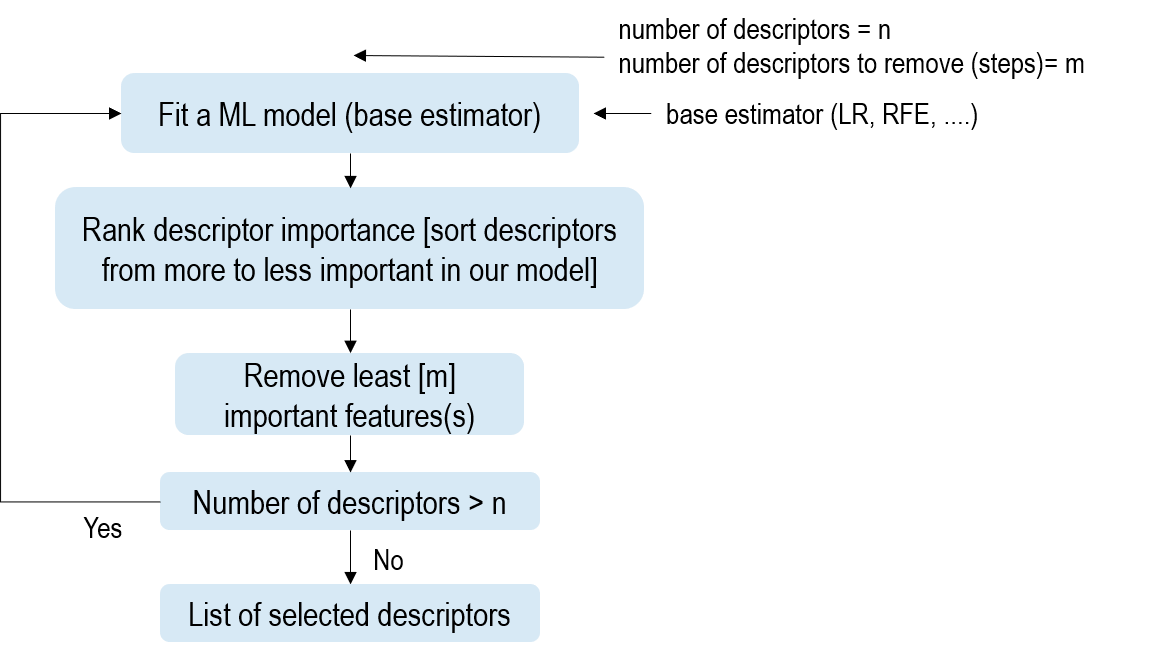


Así que comenzaremos seleccionando características con **RFE** utilizando una **Regresión Logística** como estimador base
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [ ]:
#Importa la función RFE de sklearn.feature_selection y el estimador LogisticRegression de sklearn.linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


#Read the train set and separate the descriptors array and the output variable
#Carga el dataframe df_train y separa la matriz de descriptores y la variable de salida
df_train = pd.read_csv("Earthworm_acute_toxicity_Train_descriptors_elimination.csv", sep = ';')

X = df_train.iloc[:,2:]
y = df_train.pop("y")

#Inicializa el estimador LogisticRegression
estimator = LogisticRegression()

#Establece el número de descriptores a seleccionar. Comenzaremos con 5 características.
num_features = 5
#Inicializa el selector RFE
selector = RFE(estimator, n_features_to_select=num_features, step=1)
#Ajusta el selector RFE a los datos de entrenamiento
selector = selector.fit(X,y)

#Crea un subconjunto de la matriz de descriptores con las características seleccionadas
feats_train_rfe1 = X.loc[:, selector.support_]
#Join the selected descriptors to the output variable and SMILES column
#Une los SMILES y el valor respuesta
df_train_rfe1 = pd.concat([df_train.SMILES, y, feats_train_rfe1], axis=1)

#Carga el dataframe df_test y selecciona solo las columnas de descriptores de interés
df_test = pd.read_csv("Earthworm_acute_toxicity_Test_descriptors_elimination.csv", sep = ';')
descr_test = df_test.loc[:,list(feats_train_rfe1.columns)]
df_test_rfe1 = pd.concat([df_test.loc[:,["SMILES","y"]], descr_test], axis=1)

#Guarda ambos dataframes como archivos csv, no cambies los nombres ya que se utilizan más adelante
df_train_rfe1.to_csv("Earthworm_acute_toxicity_Train_RFE_logreg_nonupdated.csv", index=False)
df_test_rfe1.to_csv("Earthworm_acute_toxicity_Test_RFE_logreg_nonupdated.csv", index=False)

print("The features selected are:")
for feat in list(feats_train_rfe1.columns):
    print("\n",feat)

### **Q2.** ¿Cuáles son las características seleccionadas utilizando este enfoque?

Como viste en el código anterior, elegimos un número arbitrario de características (5 en nuestro caso).
Es interesante tener en cuenta que existe una proporción límite de características por molécula. Idealmente, deberías utilizar como máximo una característica por cada 5 moléculas en el conjunto de entrenamiento.

Comprueba cuál es el número máximo de características que puedes utilizar en nuestro caso:

In [ ]:
max_num_features = _____________________

print("The maximum number of features to use is: ", str(max_num_features))

Puedes elegir un número diferente de características si quieres experimentar.
Reutiliza el código en la siguiente celda e intenta obtener una cantidad distinta.
Recuerda cambiar el nombre del archivo para no sobrescribirlo, ya que lo necesitarás en la próxima sesión práctica.

In [ ]:
#ESCRIBE AQUÍ TU CÓDIGO

En la siguiente celda, completa el código para utilizar un estimador de árbol de decisión
(https://scikit-learn.org/stable/modules/tree.html) para seleccionar 5 características mediante RFE.

Como estimador base, vamos a utilizar principalmente los hiperparámetros por defecto del árbol de decisión, excepto el parámetro random_state.
Como ocurrió con la división del conjunto de datos, la aleatoriedad puede suponer un problema para la reproducibilidad.
Por ello, en este curso vamos a utilizar una semilla fija de 2025 en todos los pasos que involucren aleatoriedad.

In [ ]:
#Importa la función RFE de sklearn.feature_selection y el estimador DecisionTreeClassifier de sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

#Read the train set and separate the descriptors array and the output variable
#Carga el juego de datos de entrenamiento y separa la matriz de descriptores y la variable de salida
df_train = pd.read_csv("Earthworm_acute_toxicity_Train_descriptors_elimination.csv", sep = ';')
X = df_train.iloc[:,2:]
y = df_train.pop("y")

#Inicializa el estimador DecisionTreeClassifier
estimator = ___________________(random_state=2025)

#Establecemos el número de descriptores a seleccionar. Comenzaremos con 5.
num_features = _______________
#Inicia el selector RFE
selector = __________________________
#Ajusta el selector RFE a los datos de entrenamiento
selector = selector.fit(X,y)

#Crea un subconjunto de la matriz de descriptores con las características seleccionadas
feats_train_rfe2 = X.loc[:, selector.support_]
#Junta los SMILES y el valor respuesta
df_train_rfe2 = pd.concat([df_train.SMILES, y, feats_train_rfe2], axis=1)

#Carga el juego de datos de test y selecciona solo las columnas de descriptores de interés
df_test = pd.read_csv("Earthworm_acute_toxicity_Test_descriptors_elimination.csv", sep = ';')
descr_test = df_test.loc[:,list(feats_train_rfe2.columns)]
df_test_rfe2 = pd.concat([df_test.loc[:,["SMILES","y"]], descr_test], axis=1)

#Guarda ambos DataFrames como archivos csv, no cambies los nombres ya que se utilizan más adelante
df_train_rfe2.to_csv("Earthworm_acute_toxicity_Train_RFE_dectree_nonupdated.csv", index=False)
df_test_rfe2.to_csv("Earthworm_acute_toxicity_Test_RFE_dectree_nonupdated.csv", index=False)

print("The features selected are:")
for feat in list(feats_train_rfe2.columns):
    print("\n",feat)

### Algoritmo de Importancia por Permutación (PI)
Vamos a probar otro método para seleccionar características. Esta vez se trata de la Importancia por Permutación (PI). Consulta este enlace para obtener más información sobre cómo funciona:
https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

Como puedes ver, también se basa en un algoritmo de aprendizaje supervisado que actúa como estimador para determinar la importancia de cada característica.

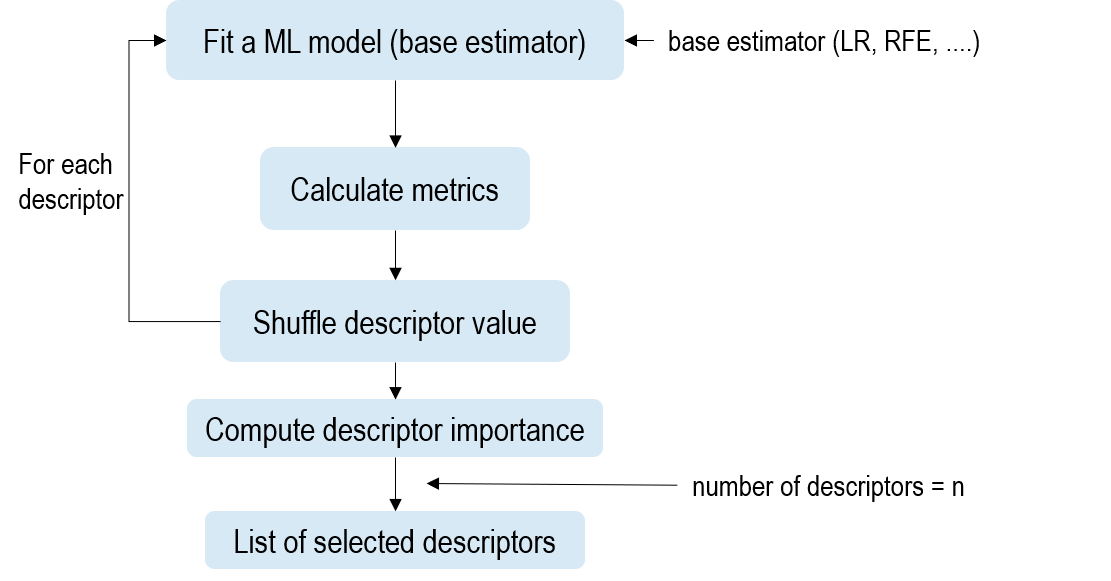









En este caso trabajaremos con un paquete diferente (eli5), por lo que primero necesitaremos instalarlo.

Al usar Importancia por Permutación, vamos a utilizar la Regresión Logística como estimador base, como hicimos antes con RFE.
Revisa el siguiente código y ejecuta la celda para obtener las importancias de las características.

Como la Importancia por Permutación utiliza aleatoriedad para desordenar los valores de los descriptores, es conveniente incluir un `random_state` para garantizar la reproducibilidad (en este curso utilizaremos 2023).

In [ ]:
#Importa las librerías necesarias
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from eli5.sklearn import PermutationImportance

#Carga el juego de datos de entrenamiento y separa la matriz de descriptores y la variable de salida
df_train = pd.read_csv("Earthworm_acute_toxicity_Train_descriptors_elimination.csv", sep = ';')
X = df_train.iloc[:,2:]
y = df_train.pop("y")

#Inicializa el estimador LogisticRegression
estimator = LogisticRegression()

#Ajusta el estimador a los datos de entrenamiento
estimator.fit(X, y)
#Ajusta el permutador a los datos de entrenamiento usando el estimador
perm = PermutationImportance(estimator,random_state=2025).fit(X, y)



#Usamos el atributo perm.feature_importances_ para la selección de características
#Seleccionamos las características que aumentan la precisión al menos 0.01
sel = SelectFromModel(perm, threshold=0.01, prefit=True)


#Obtén las características y las importancias en un dataframe y ordénalas para ver cuáles son más importantes
importances = list(perm.feature_importances_)
features_permutation = list(X.columns)

dataframe_permutation = pd.DataFrame({'feature' : features_permutation,
                            'importance' : importances},
                            columns=['feature','importance'])

dataframe_permutation_ordered = dataframe_permutation.sort_values('importance',ascending=False)

print(dataframe_permutation_ordered)


Revisa los valores de importancia en el DataFrame impreso. Según estos valores, ¿cuántos descriptores elegirías para construir un modelo?

Nota: No te preocupes si este método no arroja características importantes. Es un comportamiento normal, aunque no deseado.
Este tipo de resultado sugiere que el uso de este estimador base no es útil con este método.

Aun así, puedes elegir un número de características e insertarlo en la variable pi_n_feats, para que podamos seleccionarlas y guardarlas en un archivo CSV.
Sin embargo, no utilizaremos este método en la siguiente parte, ya que los valores obtenidos mediante PI no son adecuados.

In [ ]:
#Elige el número de descriptores a seleccionar.
pi_n_feats = ___________

#Crea un subconjunto de la matriz de descriptores con las características seleccionadas
feat_select_pi = list(dataframe_permutation_ordered.iloc[:pi_n_feats,0])
feats_train_pi1 = X.loc[:,feat_select_pi]

#Une los SMILES y el valor respuesta
df_train_pi1 = pd.concat([df_train.SMILES, y, feats_train_pi1], axis=1)

#Carga el juego de datos de test y selecciona solo las columnas de descriptores de interés
df_test = pd.read_csv("Earthworm_acute_toxicity_Test_descriptors_elimination.csv", sep = ';')
descr_test = df_test.loc[:,list(feats_train_pi1.columns)]
df_test_pi1 = pd.concat([df_test.loc[:,["SMILES","y"]], descr_test], axis=1)

#Guarda ambos dataframes como archivos csv
df_train_pi1.to_csv("Earthworm_acute_toxicity_Train_PI_logreg_nonupdated.csv", index=False, sep = ';')
df_test_pi1.to_csv("Earthworm_acute_toxicity_Test_PI_logreg_nonupdated.csv", index=False, sep = ';')

print("The features selected are:")
for feat in list(feats_train_pi1.columns):
    print("\n",feat)

Probemos el algoritmo de **Árbol de Decisión** como estimador, como hicimos antes con **RFE**.
Rellena los espacios en el siguiente código y ejecuta la celda para obtener las importancias de las características.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn import PermutationImportance
#Importa el estimador DecisionTreeClassifier de sklearn.tree



#Carga el juego de datos de entrenamiento y separa la matriz de descriptores y la variable de salida
df_train = pd.read_csv("Earthworm_acute_toxicity_Train_descriptors_elimination.csv", sep = ';')
X = df_train.iloc[:,2:]
y = df_train.pop("y")

#Inicializa el estimador DecisionTreeClassifier
estimator = _______________

#Ajusta el estimador a los datos de entrenamiento
estimator.fit(X, y)
#Ajusta el permutador a los datos de entrenamiento usando el estimador
perm = PermutationImportance(estimator).fit(X, y)

#Usamos el atributo perm.feature_importances_ para la selección de características
#Seleccionamos las características que aumentan la precisión al menos 0.01
sel = SelectFromModel(perm, threshold=0.01, prefit=True)

#Obtén las características y las importancias en un dataframe y ordénalas para ver cuáles son más importantes
importances_ = list(perm.feature_importances_)
features__permutation = list(X.columns)

dataframe_permutation = pd.DataFrame({'feature' : features__permutation,
                            'importance' : importances_},
                            columns=['feature','importance'])

dataframe_permutation_ordered = dataframe_permutation.sort_values('importance',ascending=False)

print(dataframe_permutation_ordered)


En este caso deberías obtener valores distintos de cero en las primeras características.
Ejecuta la siguiente celda para ver las importancias de las características representadas en un gráfico de barras, y utiliza un enfoque visual para decidir el número de descriptores deseados.

In [ ]:
#@title Graph to visualize feature importances
%matplotlib inline

import matplotlib.pyplot as plt

df_plot = dataframe_permutation_ordered.iloc[:20,:].sort_values('importance',ascending=True)

df_plot.plot(
    x="feature",
    kind = "barh",
    stacked = False,
    title = "Feature importances")


Según lo que has visto, ¿cuántos descriptores elegirías para construir un modelo?
Recuerda que calculamos un límite basado en el número de moléculas en el conjunto de entrenamiento. ¿Es esto un problema en este caso?

Introduce el número de características seleccionadas en la variable pi_n_feats para que podamos seleccionarlas y guardarlas en un archivo CSV.


### **Q3.** ¿Cuántos descriptores con importancia significativa has encontrado?

In [ ]:
#Elige el número de descriptores a seleccionar

pi_n_feats = _____________


#Crea un subconjunto de la matriz de descriptores con las características seleccionadas
feat_select_pi = list(dataframe_permutation_ordered.iloc[:pi_n_feats,0])
feats_train_pi1 = X.loc[:,feat_select_pi]

#Une los SMILES y el valor respuesta
df_train_pi1 = pd.concat([df_train.SMILES, y, feats_train_pi1], axis=1)

#Carga el juego de datos de test y selecciona solo las columnas de descriptores de interés
df_test = pd.read_csv("Earthworm_acute_toxicity_Test_descriptors_elimination.csv", sep=';')
descr_test = df_test.loc[:,list(feats_train_pi1.columns)]
df_test_pi1 = pd.concat([df_test.loc[:,["SMILES","y"]], descr_test], axis=1)

#Guarda ambos dataframes como archivos csv
df_train_pi1.to_csv("Earthworm_acute_toxicity_Train_PI_dectree_nonupdated.csv", index=False, sep = ';')
df_test_pi1.to_csv("Earthworm_acute_toxicity_Test_PI_dectree_nonupdated.csv", index=False, sep = ';')

print("The features selected are:")
for feat in list(feats_train_pi1.columns):
    print("\n",feat)

### Sección 3: Actualización de la imputación / escalado

Es importante tener en cuenta que, una vez que hemos seleccionado un conjunto de características, estas son las únicas que deben considerarse en el modelo.
Por lo tanto, conviene revisar nuevamente el paso de imputación, ya que el criterio que determinaba qué compuestos eran más similares (y se usaban para hacer la media) incluía todos los descriptores disponibles.
Así pues, vamos a repetir los pasos de imputación y escalado/estandarización, pero solo con los descriptores seleccionados.

La idea es repetir estos pasos sobre los conjuntos de datos que contengan únicamente las características seleccionadas.

Escribiremos una función que realice este proceso automáticamente para todos los DataFrames que contengan las variables seleccionadas. Esta función hará lo siguiente:

1. Leer los DataFrames de entrenamiento y prueba con los valores originales de los descriptores.

1. Filtrar estos DataFrames utilizando las columnas de los descriptores seleccionados.

1. Ajustar (fit) el KNNImputer con el DataFrame de entrenamiento y transformar tanto entrenamiento como prueba.

1. Ajustar (fit) el Scaler con el DataFrame de entrenamiento y transformar ambos conjuntos también.

Como puedes imaginar, necesitaremos como entradas (inputs):

* Los DataFrames originales

* Un archivo con las columnas filtradas (las características seleccionadas)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


def imputer_scaler(df_target, df_reference, columns_descriptors):

    imputer = KNNImputer(missing_values=np.nan, n_neighbors=3, weights="uniform")
    scaler = StandardScaler()

    print(columns_descriptors)

    reference_descriptors_matrix = df_reference[columns_descriptors]
    target_descriptors_matrix = df_target[columns_descriptors]
    imputer.fit(reference_descriptors_matrix)



    imputed_ref_matrix = imputer.transform(reference_descriptors_matrix)
    imputed_tag_matrix = imputer.transform(target_descriptors_matrix)



    scaler.fit(imputed_ref_matrix)


    imputed_scaled_tag_matrix = scaler.transform(imputed_tag_matrix)
    imputed_scaled_ref_matrix = scaler.transform(imputed_ref_matrix)
    df_imputed_scaled = pd.DataFrame(imputed_scaled_tag_matrix, columns = columns_descriptors)


    smiles_target = list(df_target['SMILES'])

    y_target = list(df_target['y'])

    df_imputed_scaled.insert(0,'SMILES',smiles_target)
    df_imputed_scaled.insert(1,'y',y_target)

    return df_imputed_scaled





Ahora deberías usar esta función para actualizar los archivos creados por los métodos supervisados.
Ten en cuenta que los archivos que deberás utilizar en la siguiente lección son los nuevos archivos creados aquí, sin el sufijo _nonupdated.

In [ ]:
combinations_algorithms_base_estimators = ['RFE_logreg', 'RFE_dectree','PI_dectree']

for combination in combinations_algorithms_base_estimators:
    print('processing ', combination)

    #Carga el archivo con los descriptores seleccionados y lee el nombre de los descriptores
    file_with_descriptors = pd.read_csv('Earthworm_acute_toxicity_Train_{}_nonupdated.csv'.format(combination), sep = ';')
    list_with_descriptors = file_with_descriptors.columns[2:]


    #Procesa el archivo de entrenamiento sin transformar solo con los descriptores seleccionados
    df_train_original = pd.read_csv("Earthworm_acute_toxicity_Train.csv", sep = ';')
    output_name_train =  'Earthworm_acute_toxicity_Train_{}.csv'.format(combination)
    final_train = imputer_scaler(df_train_original,df_train_original,list_with_descriptors)
    final_train.to_csv(output_name_train,index = False, sep = ';')

    #Procesa el archivo de validación sin transformar solo con los descriptores seleccionados
    df_test_original = pd.read_csv("Earthworm_acute_toxicity_Test.csv")
    output_name_test =  'Earthworm_acute_toxicity_Test_{}.csv'.format(combination)
    final_test = imputer_scaler(df_test_original,df_train_original,list_with_descriptors)
    final_test.to_csv(output_name_test,index = False, sep = ';')

    print('processed ', combination ,'\n')



